In [1]:
from qiskit import *
from math import pi
import math
import numpy as np
from qiskit.aqua.operators import CircuitStateFn
from qiskit.aqua.operators.gradients import QFI
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
import time

In [2]:
numQubits = 4  #Number of Qubits in the circuit
numParametrisedLayers = 2

In [3]:
X = np.random.uniform(-1, 1, numQubits)  #data vector X, normalised between [-1, 1]

In [4]:
params = ParameterVector('θ_', length = numQubits*numParametrisedLayers) #vector of parameters (for the Variational Circuit)
theta_iter = iter(params) #iterates over the instances of vector "params"

In [5]:
def add_layerRZ():
    for i in range(numQubits):
        qf.rz(X[i], i)
    qf.barrier()

In [6]:
def add_layerRZZ():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qf.cx(i, j)
            qf.rz((pi-X[i])*(pi-X[j]), j)
            qf.cx(i, j)
        qf.barrier()

In [7]:
def make_feature_map():
    for i in range(numQubits):
        qf.h(i)
    qf.barrier()
    add_layerRZ()
    add_layerRZZ()

In [8]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qf.cx(i, j)
    qf.barrier()

In [9]:
def add_layerRY():
    for qubit in range(numQubits):
        qf.ry(next(theta_iter), qubit)
    qf.barrier()

In [10]:
def make_variationalCircuit():
    add_layerRY()
    add_cnots()
    add_layerRY()

In [11]:
qf = QuantumCircuit(QuantumRegister(numQubits)) 

In [12]:
def make_final_circuit():
    make_feature_map()
    make_variationalCircuit()

In [13]:
make_final_circuit()

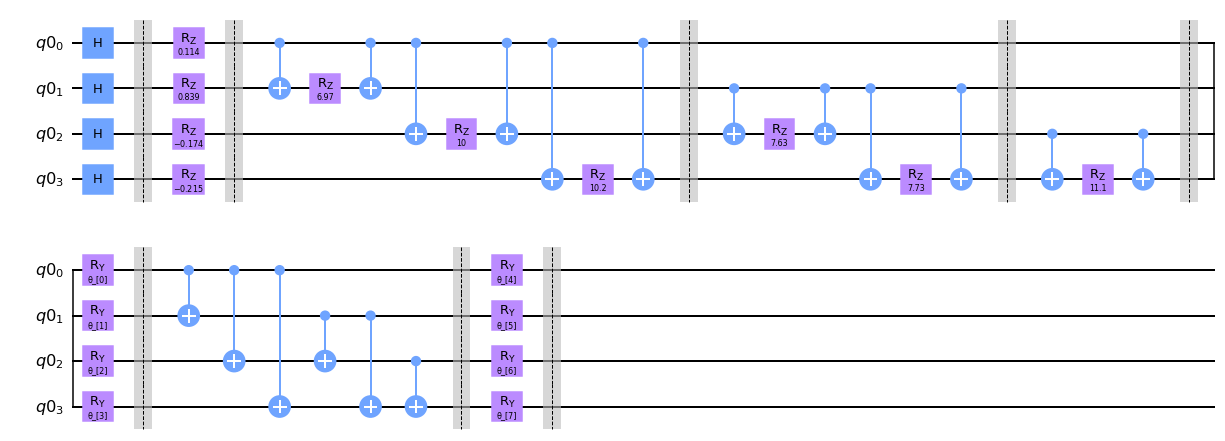

In [14]:
qf.draw('mpl')

In [15]:
state = CircuitStateFn(primitive=qf, coeff=1.)

In [16]:
start_qfi = time.time()
qfi = qiskit.aqua.operators.gradients.QFI(qfi_method='lin_comb_full').convert(operator=state, params=params.params)
values_dict = {params: np.random.uniform(-1, 1, numQubits*numParametrisedLayers)} 
qfi_result = qfi.assign_parameters(values_dict).eval()
end_qfi = time.time()
print(end_qfi - start_qfi)

9.921360492706299


In [17]:
print('full QFI \n', np.real(np.array(qfi_result)))

full QFI 
 [[ 9.97168149e-01  1.45746080e-01  4.28391700e-02 -2.05665139e-02
   2.81218211e-01 -2.40184205e-02  2.46720761e-02  1.81698026e-01]
 [ 1.45746080e-01  9.99753437e-01  3.60054023e-01  2.90553282e-01
  -9.81946886e-04 -1.16289614e-01 -4.70869666e-04  2.32793319e-01]
 [ 4.28391700e-02  3.60054023e-01  9.99983692e-01  5.89191873e-01
  -2.52532924e-04 -1.82264875e-03  5.67805398e-03 -3.29051592e-04]
 [-2.05665139e-02  2.90553282e-01  5.89191873e-01  9.99993290e-01
  -1.61985366e-04 -1.16912448e-03 -7.76762940e-05 -1.48373364e-02]
 [ 2.81218211e-01 -9.81946886e-04 -2.52532924e-04 -1.61985366e-04
   9.96089353e-01 -7.98099275e-02 -3.23403532e-01 -3.37396450e-01]
 [-2.40184205e-02 -1.16289614e-01 -1.82264875e-03 -1.16912448e-03
  -7.98099275e-02  7.96287101e-01 -1.21966309e-01 -1.55825775e-01]
 [ 2.46720761e-02 -4.70869666e-04  5.67805398e-03 -7.76762940e-05
  -3.23403532e-01 -1.21966309e-01  9.99100763e-01  6.21085977e-01]
 [ 1.81698026e-01  2.32793319e-01 -3.29051592e-04 -1.48373

In [19]:
fisher_matrix = np.real(np.array(qfi_result))
d = numQubits*numParametrisedLayers

In [20]:
def V_theta():
    return 2 ** d

In [24]:
def normalised_matrix():
    denominator = (2**d)*np.trace(fisher_matrix)          #integrate.quad(np.trace(fisher_matrix), 0, 2*pi)
    #d = numQubits*numParametrisedLayers
    return d*(V_theta()/denominator)*fisher_matrix

In [25]:
normalised_matrix()

array([[ 1.02513693e+00,  1.49833997e-01,  4.40407322e-02,
        -2.11433678e-02,  2.89105879e-01, -2.46920943e-02,
         2.53640837e-02,  1.86794331e-01],
       [ 1.49833997e-01,  1.02779473e+00,  3.70152895e-01,
         2.98702782e-01, -1.00948874e-03, -1.19551329e-01,
        -4.84076718e-04,  2.39322755e-01],
       [ 4.40407322e-02,  3.70152895e-01,  1.02803145e+00,
         6.05717652e-01, -2.59616021e-04, -1.87377079e-03,
         5.83731324e-03, -3.38280901e-04],
       [-2.11433678e-02,  2.98702782e-01,  6.05717652e-01,
         1.02804131e+00, -1.66528766e-04, -1.20191634e-03,
        -7.98549752e-05, -1.52534972e-02],
       [ 2.89105879e-01, -1.00948874e-03, -2.59616021e-04,
        -1.66528766e-04,  1.02402788e+00, -8.20484533e-02,
        -3.32474423e-01, -3.46859818e-01],
       [-2.46920943e-02, -1.19551329e-01, -1.87377079e-03,
        -1.20191634e-03, -8.20484533e-02,  8.18621531e-01,
        -1.25387246e-01, -1.60196409e-01],
       [ 2.53640837e-02, -4.840767

In [26]:
np.trace(normalised_matrix())*(2**d)/V_theta()

8.0

In [31]:
def effective_dimension(n, gamma):
    factor = (gamma*n)/(2*pi*math.log(n))
    determinant = np.linalg.det(factor*fisher_matrix + np.identity(fisher_matrix.shape[0]))
    integrate_det = (2**d)*(determinant**0.5)
    return 2*math.log(integrate_det/V_theta())/math.log(factor)

In [35]:
nos = np.arange((10**5), 10**6, 10**3) #no of data samples (can't be taken as 1, otherwise log(1) gives division by zero error)
gamma = np.linspace(0.01, 1.0, num = 20)

In [37]:
for i in range(20):
    for j in range(20):
        print("n : {}, gamma : {}, Effective Dimension : {}".format(nos[i], gamma[j], effective_dimension(nos[i], gamma[j])/8))

n : 100000, gamma : 0.01, Effective Dimension : 0.9516308726374003
n : 100000, gamma : 0.06210526315789474, Effective Dimension : 0.9521157804584338
n : 100000, gamma : 0.11421052631578947, Effective Dimension : 0.9562896184207278
n : 100000, gamma : 0.16631578947368422, Effective Dimension : 0.9587541766169374
n : 100000, gamma : 0.21842105263157896, Effective Dimension : 0.9604446965612401
n : 100000, gamma : 0.2705263157894737, Effective Dimension : 0.9617081315047943
n : 100000, gamma : 0.32263157894736844, Effective Dimension : 0.9627051367341967
n : 100000, gamma : 0.37473684210526315, Effective Dimension : 0.9635218855091262
n : 100000, gamma : 0.4268421052631579, Effective Dimension : 0.9642094731035808
n : 100000, gamma : 0.4789473684210527, Effective Dimension : 0.9648004708656646
n : 100000, gamma : 0.5310526315789474, Effective Dimension : 0.9653168100194899
n : 100000, gamma : 0.5831578947368421, Effective Dimension : 0.9657739038418306
n : 100000, gamma : 0.63526315789473